## Nouvelle section

In [ ]:
 ## GET helper functions
import sys
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper_functions
import tensorflow as tf
import tensorflow_hub as hub
SAVE_DIR = "model_logs"

In [ ]:
# Function to evaluate : accuracy, precision, recall, f1-score<
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# rajouter
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
helper_functions.download_file("https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip","nlp_getting_started.zip")

In [ ]:
helper_functions.unzip_data("nlp_getting_started.zip")

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()
# train_df["text"][0]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
# frac : nb of % to shuffle 1=100%
train_df_shuffled = train_df.sample(frac=1, random_state = 42)
test_df_shuffled = train_df.sample(frac=1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ### Introduction to NLP Fundamentals in TensorFlow
# 
#     NLP has the goal of deriving information out of natural language (could be sequences text or speech)
# 
#     Another common term for NLP problems is sequence to sequence problems (seq2seq)


# Check for GPU






# # Get a text dataset
# 
#     The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaste or not disasterrs)
# 
#     See the original source here : https://www.kaggle.com/competitions/nlp-getting-started/data










# What does the test dataframe look like ?
test_df.head()




# How many examples of each class ?
train_df.target.value_counts()




# How many total sample ?
len(train_df), len(test_df)



#  Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of  samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target:{target}", "(real diaster)" if target > 0 else "(not real diaster)")
    print(f"Text:\n{text}\n")
    print("---\n")


# ### Split data into training and validation sets


from sklearn.model_selection import train_test_split



# turn dataframe values to dataframe columns
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                    train_df_shuffled["target"].to_numpy(),
                                                    test_size = 0.1, # use 10% of traianing data for validations
                                                    random_state = 42)


# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

Target:1 (real diaster)
Text:
@Miss_HoMaStToPa cause were on fire we are on fire were on fire now.. Yeah were on fire we are on fire were on fire nowwwwww

---

Target:1 (real diaster)
Text:
Railways caught unawares by MP tragedy; Accident spot never marked as 'vulnerable' - Times ofÛ_ http://t.co/cEdCUgEuWs #News

---

Target:0 (not real diaster)
Text:
Advice from Noah: Dont go running in a thunderstorm

---

Target:1 (real diaster)
Text:
UNR issues Severe Thunderstorm Warning [wind: 60 MPH hail: 0.75 IN] for Weston [WY] and Custer Fall River Lawrence Meade Pennington [SÛ_

---

Target:1 (real diaster)
Text:
Virgin galactic crash: early unlocking of brakes triggered structural failure http://t.co/Kp1hDchfNZ

---



(6851, 762, 6851, 762)

In [ ]:




# # Reshape data
# train_sentences = train_sentences.reshape(-1, 1)
# train_labels = train_labels.reshape(-1, 1)
# val_labels = val_labels.reshape(-1, 1)
# val_sentences = val_sentences.reshape(-1, 1)
# train_sentences.shape, train_labels.shape, val_labels.shape, val_sentences.shape




# check the first 10 samples
train_sentences[:10], train_labels[:10]


# ## Converting text into numbers
# 
#     When dealing with a text problem, on of the first things you'll have to do before you can build a model is to convert your text to numbers.
# 
#     There are a few ways to do this, namely:
#      * Tokenization - direct mapping of token (a token could be a word or a caracter) to number
#      * Embedding - create a matric of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

# # Text vectorization (tokenization)



train_sentences[:5]


import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorization = TextVectorization(max_tokens=50000, # how many words in the vocabulary(utomatically add <OOV>)
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None, # Create groups of n-words?
                                       output_mode="int", # How to map tokens to numbers
                                       output_sequence_length=None, # how longdo you want your sequences to be?
                                       pad_to_max_tokens=True)



train_sentences[0].split()



# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])) # nb of words
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # average for 1 sentence


# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be 

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                   output_mode = "int",
                                   output_sequence_length= max_length)



# Fit the text vectorizer  to the training text 
# that convert our words data to numeric format 
text_vectorizer.adapt(train_sentences)

# Create a sample sentences and tokenize it 
sample_sentence = "There's a flood in my street !"
text_vectorizer([sample_sentence])

# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"Origina text:\n{random_sentence}\
\n\n Vectorized version:")
text_vectorizer([random_sentence])

# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")


# ## Creating an Embedding using an Embedding Layer
# 
#     To make our embedding, we re going to use TensorFlow's embedding layer : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
#     The parameters we xare most about for our embedding layer:
#     *`input_dim` = the size of our vocabulary
#     *`output_dim` = the size of the output embedding vector, for example, a value of 100 could mean each token gets represented by a vector 100 long
#     * `input_length` = length of the sequences being passed to the embedding layer


from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)
embedding

# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
\n\n Embedded version :")
# Embed the random sentence (turn it into danse victors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))

#sample_embed = tf.reshape(sample_embed, (1, 15, 128))
sample_embed


# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence


# ## Modelling a text dateset (running a series of experimente)
# 
#     Now we ve a got way to turn our text sequences into numbers,
#     it's time to start building a series of modelling experiments.
# 
#     We'll start with a baseline and moce on from there.
# 
# * Model 0: Naive Bayes (baseline) with sklearn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
# * Model 1: Feed-forward neural network (danse model)
# * Model 2 : LSTM model (RNN)
# * model 3 : GRU model (RNN)
# * model 4 : Bidirectional-LSTM model (RNN)
# * Model 5 : 1D Convolutional Neural Network (CNN)
# * Model 6 : TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
# * Model 7 : Same as model 6 with 10% of training data
# 
# How are we going to approch all of these ?
# 
# Use the standard steps in modelling with tensorflow:
# 
# * Create a model 
# * Build a model
# * Fit a model
# * Evaluate model

# ### Model 0 : Getting a baseline
# 
# As with all machine learning modelling experiments, it's important to create a baseline model so you're got a benchmark for future experiments to build upon.
# 
# To create our baseline, we'll use Sklearn's Multinomial Naive Bayers using the TF-IDF formula to convert our words to numbers
# 
# >** note : ** it's common practice to use non-Deep Learning Algorithms as a baseline because of their speed and then later using Deep Learning to to see if you can imporove upon them.


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline ([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text clf : juste classification
])

# Fit the pipleine to the training data
model_0.fit(train_sentences, train_labels)


# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achives an accuracy of : {baseline_score}")

# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]
# for i in range(0,10,1):
#     print(f" {val_sentences[i]} \n prediction : {baseline_preds[i]}")
    


# ### Creating an evaluation function for our model experiments
# 
# We could evaluate all of our model's predictions with different metrics every time, however this will be cumbersome and could easily be fixed with function
# 
# Let's create one to compare our model's predictions with the truth labels using the following metrics:
# * Accuracy.
# * Precision.
# * Recall
# * F1-score
# 
# For a deep overview of many different evaluation methods, see the sklearn

# ### 


# Function to evaluate : accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# rajouter
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results


# # Model 1: A simple dense model

# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional string
x = text_vectorizer(inputs)# turn the input text into numbers
x = embedding(x) # transform the input numbers in embedding
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to on vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs
model_1 = tf.keras.Model(inputs,outputs, name="Model_1_dense")


model_1.summary()    

model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


history_model_1 = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                        experiment_name="model_1_dense")])


# Check the results
model_1.evaluate(val_sentences, val_labels)



# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape, model_1_pred_probs[0]


# Look at a single prediction
model_1_pred_probs[:10]

model_1_pred_probs.shape



# Convert model prediction probabilities to label format

model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:20]


# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                   y_pred=model_1_pred_probs)
model_1_results


baseline_results


# compare witch best between our models
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values())) 


# ## Visualizing learned embeddings
# 

# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]



max_vocab_length

# Model 1 summary
model_1.summary()


# Get the weight matrix of embedding layer
# (thse are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()
print(embed_weights[0].shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)


embed_weights


# Now we've got the embedding matric our model has learned to represent our tokens, let's see how we can visualize it.
# 
# To do so, TensorFlow has a handly tool called projector: https://projector.tensorflow.org/
# 
# And TensorFlow also has an incredible guide on word embeddings themselves
# https://www.tensorflow.org/text/guide/word_embeddings


# # Create embedding files (we got this from TensorFlow's word embedding documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[0][index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()


# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass


# Downloading the files above can visualize them usign http://projector.tensorflow.org/ and clicking the "load" button on the left hand
# *Ressources : if you'd like to know more about embedding, I'd encourage you to check out :
# - Jay Alammer's vusualized word2vec post : https://jalammar.github.io/illustrated-word2vec/
# - TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

# ## Recurrent Neural Networks (RNN's)
# 
# RNN's are useful for sequence data.
# 
# The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later
# * Ressources :> 
# If you want an overview of the internale of a recurrent neural network, see the following : 
#     - MIT's sequence modelling lecture https://www.youtube.com/watch?v=QvkQ1B3FBqA
#     - Chris Olah's intro to LSTMs : https://colah.github.io/posts/2015-08-Understanding-LSTMs/
#     - Andrej Karphathy's the unreasonable effectiveness of recurrent neural network : http://karpathy.github.io/2015/05/21/rnn-effectiveness/
#     - https://www.youtube.com/watch?v=QvkQ1B3FBqA&t=166s

# ### Model 2 : LSTM 
# LSTM = long short term memory (one of the most popular LSTM cells)
# 
# Our structure of an RNN Typically looks like this:
# 
# ```
# Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
# ```

# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to  returns sequences=True
# print(x.shape)
x = layers.LSTM(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
# print(x.shape)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


# Get the summary 
model_2.summary()


# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model 
history_model2 = model_2.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="model_2_LSTM")]) 



# Make prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]


# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs)) # enlever les dimension en plus
model_2_preds[:10]


# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

baseline_results

np.array(list(model_1_results.values())) > np.array(list(model_2_results.values()))  


# ### Model 3 : GRU
# 
# Another popular and effective RNN component is the GRU or gated recurrent unit.
# 
# The GRU cell has similar features to an LSTM cell but has less parameters.

# Build an RNN GRU
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(3)(x)
# x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) 
# x = tf.keras.layers.LSTM(42, return_sequences=True)(x)
# x = tf.keras.layers.GRU(units=92, return_sequences=True)(x)

# # Apply global average pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# x = tf.keras.layers.Dense(64, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

# # Version 2
# # Build an RNN GRU
# inputs = tf.keras.layers.Input(shape=(1), dtype=tf.string)
# x = text_vectorizer(inputs)
# x = embedding(x)
# # x = tf.keras.layers.GRU(64)(x)
# x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) 
# x = tf.keras.layers.LSTM(42, return_sequences=True)(x)
# x = tf.keras.layers.GRU(units=92, return_sequences=True)(x)

# # Apply global average pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# x = tf.keras.layers.Dense(64, activation="relu")(x)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")


# Get a summary
model_3.summary()

# compile the model
model_3.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                        experiment_name="model_3_GRU")])


# Make som prediction with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)


model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))


model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

# comparing model 1 with model 2
np.array(list(model_1_results.values())) > np.array(list(model_3_results.values()))  


# # Mode 4 :  Bidirectional RNN
# 
# 

# create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu"))(x)
# x = tf.keras.layers.AveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_layer")


model_4.summary()



model_4_predict_prob = tf.squeeze(model_4.predict(val_sentences))
model_4_preds = tf.round(model_4_predict_prob)

model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results


# # Model 4 : Bidirectional RNN
# 
# Normal RNN's go from left to right (just like you'd read an English sentence), however, bidirectional RNN goes from right to left as well as left to right.
# 
# 


# Build a bidirectional RNN in TensorFlow 
# create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
print(x.shape) # nb_units * 2 comme c'est bidirectional

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_layer")



# Get a summary 
model_4.summary()


# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

history_model_4 = model_4.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="Bidirectionalmod")])


# Make prediction with our bidirectional model
model_4_predict_prob = tf.squeeze(model_4.predict(val_sentences))
# Convert pred probs to labels 
model_4_preds = tf.round(model_4_predict_prob)

# Convert pred probs to labels 
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results


# ## Convolution Neural Networks for Text (and other types of sequences)
# 
# We've used CNNs for images but images are typically 2D (geight x width)... however, our text data is 1D.
# 
# Previously we've Conv2D for our image data but now we're going to use Conv1D.
# 
# The typical structure of a Conv1D model for sequences (in our case, text):
# 
# Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typicallyConv1D + Pooling layer) -> Pooling -> Outputs (class probabilities) 

# ## Model 5 : Conv1D
# 
# For different explanations of parameters see:
# * https://poloclub.github.io/cnn-explainer/
# * Difference between "same" and "valid" padding:https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=To%20sum%20up%2C%20'valid',same'%20padding%20means%20using%20padding.



# embedding_test = embedding(text_vectorizer(["c est test de phrase"]))
# conv_1d = tf.keras.layers.Conv1D(filters=32,
#                                  kernel_size=5 , 
#                                  activation="relu",
#                                  padding="valid")
# conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
# max_pool = tf.keras.layers.GlobalAvgPool1D()
# max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

# embedding_test.shape, conv_1d_output.shape, max_pool_output.shape
# # embedding_test
# # conv_1d_output
# # max_pool_output



# Test out our embedding layer, Conv1D layer and max pooling
inputs = tf.keras.layers.Input(shape=(1), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5 , 
                           activation="relu",
                           strides=1,
                           padding="valid")(x)
x = tf.keras.layers.GlobalAvgPool1D()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1d")

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Get a summary of our Conv1D model
model_5.summary()



model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                 experiment_name="model_5_Conv1d")])



model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs
# convert model_5_pred_probs to labels 0 or 1
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
# model_5_preds


model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results


# Check witch the best 
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))




Origina text:
Governor allows parole for California school bus hijacker | Fresno Linked Local Network http://t.co/Sww0QsMxVM http://t.co/bcdP4gKokA

 Vectorized version:
Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']
Original text:
Sinkhole swallows Brooklyn intersection ÛÒ video http://t.co/1yBE5mgZL4 http://t.co/7Zog3DpdU9

 Embedded version :
Our baseline model achives an accuracy of : 0.7926509186351706
Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                     

(10000, 128)
Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_______________________________

Model: "model_4_Bidirectional_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable param

array([False, False, False, False])

### Model 6: TensorFlow Hub Pretrained Sentence Encoder
Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder : https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created  here : https://arxiv.org/abs/1803.11175 

In [ ]:
from sklearn.model_selection import train_test_split
# turn dataframe values to dataframe columns
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                    train_df_shuffled["target"].to_numpy(),
                                                    test_size = 0.1, # use 10% of traianing data for validations
                                                    random_state = 42)

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of USE pretrained embeddings
history_model_6 = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                  experiment_name="model_6_tf_hub")])


Saving TensorBoard log files to: model_logs/model_6_tf_hub/20230125-202952
Epoch 1/5
215/215 [==============================] - 7s 13ms/step - loss: 0.5023 - accuracy: 0.7897 - val_loss: 0.4461 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4134 - accuracy: 0.8151 - val_loss: 0.4374 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4002 - accuracy: 0.8203 - val_loss: 0.4328 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3921 - accuracy: 0.8272 - val_loss: 0.4281 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3847 - accuracy: 0.8302 - val_loss: 0.4239 - val_accuracy: 0.8189


In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Make prediction with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs)) # transforme to labels

24/24 [==============================] - 1s 14ms/step


In [ ]:
# Calculate model_6 performance metrics
model_6_results = calculate_results(val_labels,model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8203089036947304,
 'recall': 0.8188976377952756,
 'f1': 0.8177314483416845}

In [ ]:
len(train_df)

7613

## Model 7: TF Hub Pretrained USE but with 10% of training data
Transfer learning really helps when you don't have a large dataset.

To see how our modeel performs on a smaller dataset, let's replicate model _6 except we'll train it on 10% of data.

In [ ]:
# ## NOTE : making data splits like below leads to data leakage (model_7 trzined on 10%, out performs model_6 trained on 100% data)
# ## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST INTO TRAINING SET

# # Create subset of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()

# # len of train_sentences_10_percent and train_labels_10_percent
# print(f"len of train_sentences_10_percent : {len(train_sentences_10_percent)}")
# print(f"len of train_labels_10_percent    : {len(train_labels_10_percent)}\n")

# # Check the number of targets in our subset of data
# print("number of targets in our train_10_percent :")
# print(train_10_percent["target"].value_counts())

# print("number of targets in our train_df_shuffled :")
# print(train_df_shuffled["target"].value_counts())

To recreate a model the same as a previous model you've created you van use the `tf.keras.models/clone_model()` method, see more here : 

In [ ]:
# # Let's build a model same as model_6
# model_7 = tf.keras.models.clone_model(model_6)

# # compile the model
# model_7.compile(loss="binary_crossentropy",
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [ ]:
# # fit the data with incorrect split

# # fit the model with 10% percent data
# history_model_7_incorrect = model_7.fit(train_sentences_10_percent,
#                                         train_labels_10_percent,
#                                         epochs=5,
#                                         validation_data=(val_sentences,val_labels),
#                                         callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
#                                                                                experiment_name="tf_hub_sentence_encoder_10_percent_incorrect")])

In [ ]:
# # predict the model
# model_7_pred_probs = model_7.predict(val_sentences)

# print(f"model_7_predict_probs[:10] : \n{model_7_pred_probs[:10]}\n")

# # Turn pred probs into labels
# model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
# print(f"model_7_preds[:10] (labels): \n{model_7_preds[:10]}\n")

# # calcule results model evaluation
# model_7_incorrect_results = calculate_results(val_labels, model_7_preds)
# print(f"model_7_incorrect_results : \n{model_7_incorrect_results}\n")

In [ ]:
# Correct data split
# Making a better dataset split (no data leakage
# recup 10 percent of our previous split data train
train_10_percent_split = int(0.1*len(train_sentences))
# une technique plutot sympa
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
print(f"len(train_labels_10_percent) : {len(train_labels_10_percent)}\n")

# Check the number of each label in the updated training data subset
print("number of each label in the updated training data subset :")
pd.Series(np.array(train_labels_10_percent)).value_counts()

len(train_labels_10_percent) : 685

number of each label in the updated training data subset :


0    406
1    279
dtype: int64

In [ ]:
# Let's build a model same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model with 10% percent data
history_model_7 = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="tf_hub_sentence_encoder_10_percent_correct")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct/20230117-155117
Epoch 1/5
22/22 [==============================] - 4s 45ms/step - loss: 0.6627 - accuracy: 0.6409 - val_loss: 0.6395 - val_accuracy: 0.7060
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5868 - accuracy: 0.7869 - val_loss: 0.5806 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5125 - accuracy: 0.8161 - val_loss: 0.5314 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4557 - accuracy: 0.8146 - val_loss: 0.5031 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 23ms/step - loss: 0.4181 - accuracy: 0.8277 - val_loss: 0.4906 - val_accuracy: 0.7848


In [ ]:
# predict the model
model_7_pred_probs = model_7.predict(val_sentences)
print(f"model_7_predict_probs[:10] : \n{model_7_pred_probs[:10]}\n")

# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
print(f"model_7_preds[:10] (labels): \n{model_7_preds[:10]}\n")

# calcule results model evaluation
model_7_results = calculate_results(val_labels, model_7_preds)
print(f"model_7_results : \n{model_7_results}\n")

24/24 [==============================] - 1s 11ms/step
model_7_predict_probs[:10] : 
[[0.18132102]
 [0.57961   ]
 [0.9068097 ]
 [0.32180348]
 [0.54446566]
 [0.65905774]
 [0.8837333 ]
 [0.82229495]
 [0.8453111 ]
 [0.13688931]]

model_7_preds[:10] (labels): 
[0. 1. 1. 0. 1. 1. 1. 1. 1. 0.]

model_7_results : 
{'accuracy': 78.4776902887139, 'precision': 0.7870511640590381, 'recall': 0.7847769028871391, 'f1': 0.7827022002767159}



In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                "1_simple_dense": model_1_results,
                                "2_lstm":model_2_results,
                                "3_gru":model_3_results,
                                "4_bidirectional": model_4_results,
                                "5_conv1d": model_5_results,
                                "6_tf_hub_use_encoder": model_6_results,
                                "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.792092,0.786089,0.782703
2_lstm,0.771654,0.771482,0.771654,0.770792
3_gru,0.772966,0.773053,0.772966,0.771872
4_bidirectional,0.779528,0.781115,0.779528,0.777651
5_conv1d,0.766404,0.766590,0.766404,0.765121
6_tf_hub_use_encoder,0.804462,0.804290,0.804462,0.804341
7_tf_hub_use_encoder_10_percent,0.784777,0.787051,0.784777,0.782702


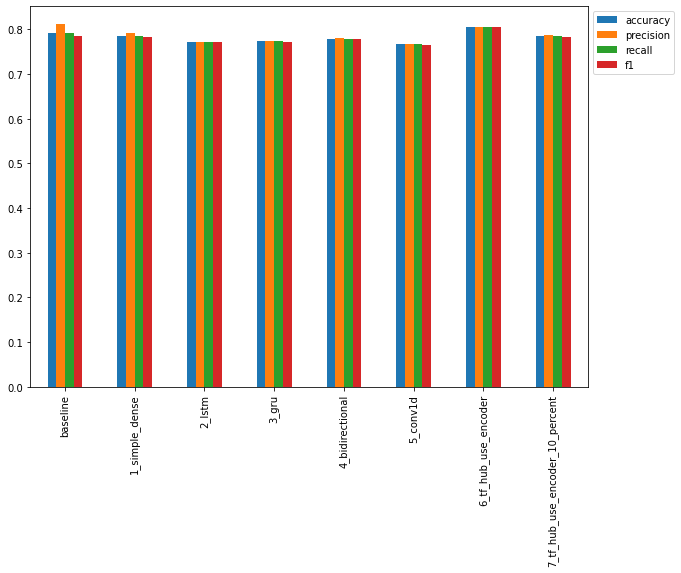

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

In [ ]:
# !tensorboard dev upload --logdir model_logs\
#     --name "models experiments" \
#     --description "Simple comparison of differents models of RNN"

Now I've ran the cell above, my modelling experiments are visible on TensorBoard.dev: https://tensorboard.dev/experiment/D50zrynvRmC44evTdw1YYg/

> Ressource: TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check options,  check out Weights & Biases https://wandb.ai/site

In [ ]:
# See the previous TensorBoard Dev experiments you've run...
#!tensorboard dev list

In [ ]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id D50zrynvRmC44evTdw1YYg

In [ ]:
# save the model

#model_0.save("save_models/model_0.H5")
#model_1.save("save_models/model_1.H5")
#model_2.save("save_models/model_2.H5")
#model_3.save("save_models/model_3.H5")
#model_4.save("save_models/model_4.H5")
#model_5.save("save_models/model_5.H5")
model_6.save("save_models/model_6.H5")
#model_7.save("save_models/model_7.H5")

In [ ]:
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("drive/MyDrive/save_models/model_6.H5",
                                     custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 10ms/step - loss: 0.4253 - accuracy: 0.8202


[0.4252946376800537, 0.8202099800109863]

In [ ]:
# Save TF Hub sentence Encoder Model to savedModel format (default)
#model_6.save("model_6_SaveModel_format")

In [ ]:
# Load in a model from the SavedModel format
#loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SaveModel_format")

In [ ]:
# Download a file with google colab
# from google.colab import files
# files.download("example.txt ")

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting  *most* wrong (those with prediction probabilities )

In [ ]:
## Finding the most wrong examples
from helper_functions import make_confusion_matrix

In [ ]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-01-17 20:26:22--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   141MB/s    in 8.9s    

2023-01-17 20:26:31 (103 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.in

In [ ]:
# Import previously trained model from google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [ ]:
model_6_pretrained.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences) 
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))


24/24 [==============================] - 1s 10ms/step


In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction label + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_probs": tf.squeeze((model_6_pretrained_pred_probs))})
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
# make_confusion_matrix(y_true=val_labels,y_pred=model_6_preds)

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs", ascending=False) 
most_wrong.head() # These are false positive

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [ ]:
most_wrong.tail() # The are false negative

,text,target,pred,pred_probs
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
  # Check the false postive (model predicted 1 when should've been 0)
  for row in  most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target : {target}, Pred: {pred}, Prob:{pred_prob}")
    print(f"text:\n{text}\n")

Target : 0, Pred: 1.0, Prob:0.9101957678794861
text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

Target : 0, Pred: 1.0, Prob:0.8769821524620056
text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

Target : 0, Pred: 1.0, Prob:0.8523000478744507
text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

Target : 0, Pred: 1.0, Prob:0.8354544639587402
text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

Target : 0, Pred: 1.0, Prob:0.8272132873535156
text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

Target : 0, Pred: 1.0, Prob:0.8148158192634583
text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

Target : 0, Pred: 1.0, Prob:0.810

In [ ]:
  # Check the false negative (model predicted 1 when should've been 0)
  for row in  most_wrong[:-10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target : {target}, Pred: {pred}, Prob:{pred_prob}")
    print(f"text:\n{text}\n")

Target : 0, Pred: 1.0, Prob:0.9101957678794861
text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

Target : 0, Pred: 1.0, Prob:0.8769821524620056
text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

Target : 0, Pred: 1.0, Prob:0.8523000478744507
text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

Target : 0, Pred: 1.0, Prob:0.8354544639587402
text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

Target : 0, Pred: 1.0, Prob:0.8272132873535156
text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

Target : 0, Pred: 1.0, Prob:0.8148158192634583
text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

Target : 0, Pred: 1.0, Prob:0.810

# Make predictions on the test dataset and visualizing them

## Methode 1 : mrdbourg

In [ ]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  model_6_pretrained_pred_probs_test = tf.squeeze(model_6_pretrained.predict(test_sentences))
  model_6_pretrained_preds =tf.round(model_6_pretrained_pred_probs_test)
  print(f"prob:{model_6_pretrained_pred_probs_test}, pred : {model_6_pretrained_preds}")
  print(f"Text:\n{test_sample}\n")
  print("-----------")

102/102 [==============================] - 1s 9ms/step
prob:[0.51997006 0.8752513  0.8278328  ... 0.9158135  0.5176442  0.6726021 ], pred : [1. 1. 1. ... 1. 1. 1.]
Text:
@swearyG It looks like the death star

-----------
102/102 [==============================] - 1s 9ms/step
prob:[0.51997006 0.8752513  0.8278329  ... 0.9158135  0.5176442  0.6726021 ], pred : [1. 1. 1. ... 1. 1. 1.]
Text:
Please sign &amp; RT to save #SaltRiverWildHorses http://t.co/GB8ispiaRP http://t.co/Bx0l87iNc8

-----------
102/102 [==============================] - 1s 9ms/step
prob:[0.51997006 0.8752513  0.8278329  ... 0.9158135  0.5176442  0.6726021 ], pred : [1. 1. 1. ... 1. 1. 1.]
Text:
Flood Advisory issued August 05 at 4:35PM EDT by NWS http://t.co/fuZ7y44P4I #WxKY

-----------
102/102 [==============================] - 1s 9ms/step
prob:[0.51997006 0.87525123 0.8278329  ... 0.9158135  0.5176442  0.67260206], pred : [1. 1. 1. ... 1. 1. 1.]
Text:
Storm rolling into Hilton Head gonna be fun

-----------
102/102 

In [ ]:
#test_sentences = test_df["text"].to_numpy()
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds.shape

24/24 [==============================] - 0s 17ms/step


TensorShape([762])

## Methode 2 : MrJuba

In [ ]:
model_6_pretrained_preds
test_df_pred =  pd.DataFrame({"sentence": test_sentences,
                              "pred": model_6_pretrained_preds,
                              "prob_preds": tf.squeeze(model_6_pretrained_pred_probs_test)})
test_df_pred

,sentence,pred,prob_preds
0,Just happened a terrible car crash,1.0,0.519970
1,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958
...,...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1.0,0.800561
3259,Storm in RI worse than last hurricane. My city...,1.0,0.967862
3260,Green Line derailment in Chicago http://t.co/U...,1.0,0.915814
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,1.0,0.517644


## Your challenge.. predicting on Tweets from the wild

Go to your favourite Twitter accound and copy on of their layers Tweets.

Then pass that Tweet through our trained model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong ?

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_time_total_pred, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_time_total_pred, model_6_time_per_pred

24/24 [==============================] - 0s 9ms/step


(0.2785869669996828, 0.0003655996942253055)

In [ ]:
# Calculate our baseline model times per pred
baseline_time_total_pred, baseline_time_per_pred = pred_timer(model=model_0, samples=val_sentences)
baseline_time_total_pred, baseline_time_per_pred

(0.016446343999632518, 2.1583128608441625e-05)

In [ ]:
# calculate results of model
model_6_pretrained_results = calculate_results(y_true = val_labels, y_pred = model_6_pretrained_preds)
model_6_pretrained_results


{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

### Ideal speed / performance trade off

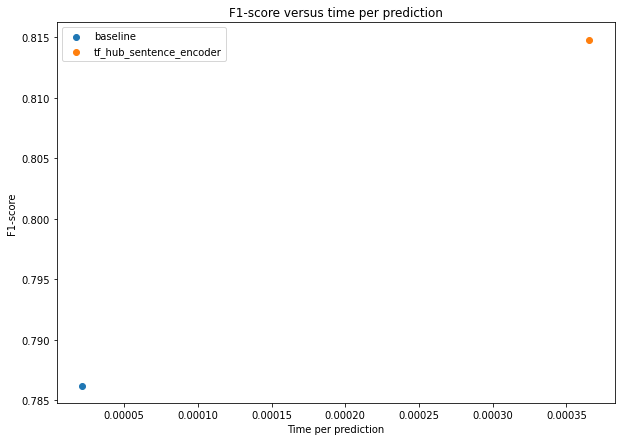

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

In [ ]:
test_twitter_sentence = "kill one or all"
test_twitter_list = [test_twitter_sentence]
test_twitter_array = np.array(test_twitter_list, dtype=object)
test_twitter_df = pd.DataFrame(test_twitter_array)

In [ ]:
model_6_pretrained_pred_probs_test = model_6_pretrained.predict(test_twitter_array)
model_6_pretrained_preds_test = tf.squeeze(tf.round(model_6_pretrained_pred_probs_test))

# test_df_pred =  pd.DataFrame({"sentence": test_twitter_list,
#                               "pred": tf.squeeze(model_6_pretrained_preds_test),
#                               "prob_preds": tf.squeeze(model_6_pretrained_pred_probs_test)})

test_df_pred =  pd.Series({"sentence": test_twitter_array,
                           "pred": tf.squeeze(model_6_pretrained_preds_test),
                           "prob_preds": tf.squeeze(model_6_pretrained_pred_probs_test)})
test_df_pred

1/1 [==============================] - 0s 68ms/step


sentence                                  [kill one or all]
pred                tf.Tensor(0.0, shape=(), dtype=float32)
prob_preds    tf.Tensor(0.1955892, shape=(), dtype=float32)
dtype: object

In [ ]:
test_twitter_df = pd.DataFrame(test_twitter_array, columns=['sentence'])
pred = tf.squeeze(model_6_pretrained_preds_test).numpy()
prob_preds = tf.squeeze(model_6_pretrained_pred_probs_test).numpy()
test_df_pred =  pd.DataFrame({"sentence": test_twitter_df['sentence'],
                              "pred": pred,
                              "prob_preds": prob_preds},
                             index= test_twitter_df.index)

,sentence,pred,prob_preds
0,kill one or all,0.0,0.195589


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
